In [1]:
# import packages
import numpy as np
import pylab as py
import pdb
import matplotlib.pyplot as plt
import math

# import spisea packages
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity

# import nbody6tools reader to read data
from nbody6tools import Reader

# import nbody62spisea to retrieve star ages
from nbody62spisea import converter

/home/wyz5rge/.local/lib/python3.9/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /scratch/wyz5rge/models/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


## Set up parameters, create isochrone grid

In [2]:
# define isochrone parameters
AKs = 0
dist = 410
evo_model = evolution.MISTv1()
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()
filt_list = ['jwst,F115W', 'jwst,F182M']
filters = ['m_jwst_F115W', 'm_jwst_F182M']
iso_dir = 'isochrones/'
metallicity = 0

In [3]:
# read nbody data
path_to_data = '../../../../../../storage/jfarias/Data/Orion/massive_clusters/M3000new/sigma0p1/fiducial/sfe_ff030/00/'
snapshot = Reader.read_snapshot(path_to_data, time = 20)

# convert snapshot values from nbody units to astrophysical, extract masses
snapshot.to_physical()

# read ages for simulated stars
cluster_table = converter.to_spicea_table(snapshot)

print(cluster_table)

        mass        isMultiple        compMass            systemMass               e                 log_a               age        
------------------- ---------- --------------------- ------------------- --------------------- ------------------ ------------------
0.38677660467533986        0.0                    [] 0.38677660467533986                   nan                nan  19.26224057185385
0.09231783947974262        0.0                    [] 0.09231783947974262                   nan                nan   19.5514140105106
 36.123316292283796        0.0                    []  36.123316292283796                   nan                nan 20.005693435668945
  6.392950509328739        0.0                    []   6.392950509328739                   nan                nan 19.370763950562367
                ...        ...                   ...                 ...                   ...                ...                ...
  6.934423197710811        1.0 [0.06417945167258093]   6.998602649383

/scratch/wyz5rge/TurbulentClusterModel/nbody62spisea/converter.py:231: RuntimeWarning: divide by zero encountered in log10
  log_a = numpy.concatenate( [numpy.full(len(singles),numpy.nan), numpy.log10(bdict['semi']) ] )


In [4]:
masses = cluster_table['mass']
level_ages = cluster_table['age']

for i in range(len(level_ages)):
    level_ages[i] = level_ages[i] * 1e6

# convert log ages from log(Myr) to log(yr)
log_ages = np.log10(level_ages)

# print(log_ages)
print("Min log age = " + str(min(log_ages)))
print("Max log age = " + str(max(log_ages)))

# print(level_ages)
print("Min level age = " + str(min(level_ages)))
print("Max level age = " + str(max(level_ages)))

Min log age = 7.283549025426875
Max log age = 7.3011536094548415
Min level age = 19210958.12830047
Max level age = 20005693.435668945


In [5]:
# find index of first binary, create array of companion masses
first_binary = 0
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        first_binary = i
        break
print(first_binary)

compMasses = []
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        compMasses.append(cluster_table['compMass'][i][0])
print(compMasses)

1383
[0.011730564894188028, 0.05478057038822213, 0.06485943635188168, 0.12253409660171809, 0.04859034515867186, 0.15443180140146529, 0.0985120249691716, 0.033028117552569486, 0.07296174171872727, 1.1957055640931418, 2.029321470134261, 0.08446092045083976, 0.057592704150663705, 0.2721473693697683, 0.028782306982601466, 0.011667292633636295, 0.34500615375747046, 0.11102967103077452, 0.05943886385861074, 0.017457505428094936, 0.06946304860174829, 0.1207850333696815, 0.010195908833252887, 0.010522529156571857, 0.08959545040191466, 0.20713306040726343, 0.04773619825452143, 0.1117515039037843, 0.4894471940265139, 0.02526523877381286, 0.07901504357069017, 0.12227410078048706, 0.32250139117240906, 0.23865769803524017, 0.23228810727596283, 0.08560962229967117, 0.10158726633004997, 0.10317263136259226, 0.03547369130947629, 0.23702588980017325, 0.22238589823246002, 0.024706430733203888, 2.8133962336914204, 0.022072263062000275, 0.05710261381527612, 0.010722441606012696, 0.2922457793227283, 0.0198

In [6]:
start = (min(level_ages) // 0.5e6) * 0.5e6
end = (max(level_ages) // 0.5e6) * 0.5e6 + 2 * 0.5e6
increment = 0.5e6  # 500,000

# Create age arrays
level_age_arr = np.arange(start, end, increment)
log_age_arr = np.log10(level_age_arr)

print(log_age_arr)
print(level_age_arr)

[7.2787536  7.29003461 7.30103    7.31175386]
[19000000. 19500000. 20000000. 20500000.]


In [7]:
# create isochrone grid - if this is the first time, then this is going to take an hour lmfao
instances = np.empty(len(log_age_arr), dtype=object)

for i in range(len(log_age_arr)):
    my_iso = synthetic.IsochronePhot(log_age_arr[i], AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)
    instances[i] = my_iso
        
print("isochrone generation done")

Changing to logg=2.50 for T= 12528 logg=2.49
Changing to logg=2.50 for T= 12355 logg=2.47
Changing to logg=2.50 for T= 12184 logg=2.44
Changing to logg=2.50 for T= 12016 logg=2.42
Changing to logg=2.50 for T= 11850 logg=2.40
Changing to logg=2.00 for T=  9222 logg=2.00
Changing to logg=2.00 for T=  9094 logg=1.97
Isochrone generation took 39.518843 s.
Making photometry for isochrone: log(t) = 7.28  AKs = 0.00  dist = 410
     Starting at:  2023-12-19 04:08:17.810778   Usually takes ~5 minutes
Starting filter: jwst,F115W   Elapsed time: 0.00 seconds
Starting synthetic photometry
M =   0.103 Msun  T =  3013 K  m_jwst_F115W = 16.21
M =   1.703 Msun  T =  8040 K  m_jwst_F115W = 10.17
M =   5.709 Msun  T = 18030 K  m_jwst_F115W = 7.45
M =  11.463 Msun  T = 20907 K  m_jwst_F115W = 4.58
M =  11.525 Msun  T = 10167 K  m_jwst_F115W = 2.37
M =  11.547 Msun  T =  3575 K  m_jwst_F115W = 0.48
M =  12.224 Msun  T =  3575 K  m_jwst_F115W = 0.41
Starting filter: jwst,F182M   Elapsed time: 13.37 second

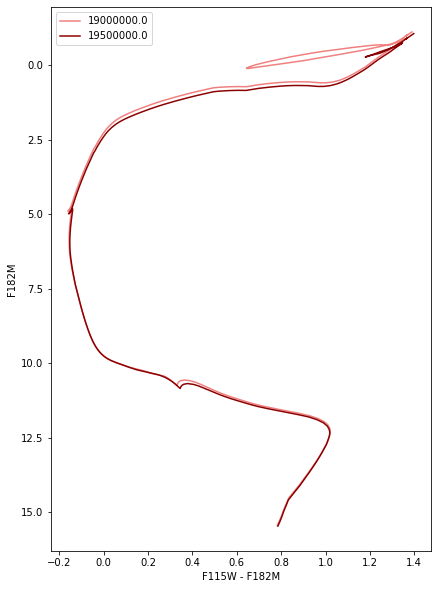

In [8]:
# identify array indeces, create array for labels and colors
idx_arr = range(0, len(log_age_arr))
if len(idx_arr) > 3:
    idx_arr = idx_arr[::2]

# Plot CMD
fig, axes = py.subplots(figsize=(15, 10))
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

In [9]:
import sys
sys.path.append('/scratch/wyz5rge/synthetic-hr/12-18')
import interpolatorExp as interpolator

level_ages_myr = level_ages / 1e6
# print(level_ages_myr)

# create array of stars
stars = np.empty(len(cluster_table), dtype=object)

# perform interpolation for each star
for i in range(len(stars)):
    # print(str(i) + " " + str(level_ages_myr[i]) + " " + str(masses[i]))
    stars[i] = interpolator.interpolate(level_ages_myr[i], masses[i], instances, log_age_arr, filters)
    
# convert luminosity values to solar luminosities
watts_to_lsun = 1.0 / (3.846e26) # conversion factor for watts to Lsun

for i in range(len(stars)):
    if stars[i] is None:
        continue
    stars[i][0] = stars[i][0] * watts_to_lsun
    
for i in range(len(stars)):
    print(stars[i])

Desired mass 0.09231783947974262 is outside the range of the isochrone.
Desired mass 0.09231783947974262 is outside the range of the isochrone.
Desired mass 36.123316292283796 is outside the range of the isochrone.
Desired mass 36.123316292283796 is outside the range of the isochrone.
Desired mass 0.023830331502852638 is outside the range of the isochrone.
Desired mass 0.023830331502852638 is outside the range of the isochrone.
Desired mass 0.01885011874476299 is outside the range of the isochrone.
Desired mass 0.01885011874476299 is outside the range of the isochrone.
Desired mass 23.0114803314209 is outside the range of the isochrone.
Desired mass 23.0114803314209 is outside the range of the isochrone.
Desired mass 19.128720071850825 is outside the range of the isochrone.
Desired mass 19.128720071850825 is outside the range of the isochrone.
Desired mass 0.05258214792958986 is outside the range of the isochrone.
Desired mass 0.05258214792958986 is outside the range of the isochrone.


Desired mass 0.08385888100279569 is outside the range of the isochrone.
Desired mass 0.08385888100279569 is outside the range of the isochrone.
Desired mass 0.061057450884563644 is outside the range of the isochrone.
Desired mass 0.061057450884563644 is outside the range of the isochrone.
Desired mass 0.0772940909006237 is outside the range of the isochrone.
Desired mass 0.0772940909006237 is outside the range of the isochrone.
Desired mass 0.05292424294491794 is outside the range of the isochrone.
Desired mass 0.05292424294491794 is outside the range of the isochrone.
Desired mass 0.08932677543025769 is outside the range of the isochrone.
Desired mass 0.08932677543025769 is outside the range of the isochrone.
Desired mass 0.03402640074919411 is outside the range of the isochrone.
Desired mass 0.03402640074919411 is outside the range of the isochrone.
Desired mass 0.017194437189212312 is outside the range of the isochrone.
Desired mass 0.017194437189212312 is outside the range of the i

Desired mass 0.08486733406875001 is outside the range of the isochrone.
Desired mass 0.08486733406875001 is outside the range of the isochrone.
Desired mass 0.09104342170244058 is outside the range of the isochrone.
Desired mass 0.09104342170244058 is outside the range of the isochrone.
Desired mass 0.0930595251238339 is outside the range of the isochrone.
Desired mass 0.0930595251238339 is outside the range of the isochrone.
Desired mass 0.03273091771230353 is outside the range of the isochrone.
Desired mass 0.03273091771230353 is outside the range of the isochrone.
Desired mass 0.023744913919861096 is outside the range of the isochrone.
Desired mass 0.023744913919861096 is outside the range of the isochrone.
Desired mass 0.06689780473645728 is outside the range of the isochrone.
Desired mass 0.06689780473645728 is outside the range of the isochrone.
Desired mass 0.01764275315988328 is outside the range of the isochrone.
Desired mass 0.01764275315988328 is outside the range of the iso

Desired mass 0.0936002216678567 is outside the range of the isochrone.
Desired mass 0.0936002216678567 is outside the range of the isochrone.
Desired mass 0.047849511338151025 is outside the range of the isochrone.
Desired mass 0.047849511338151025 is outside the range of the isochrone.
Desired mass 0.09913126335556809 is outside the range of the isochrone.
Desired mass 0.09913126335556809 is outside the range of the isochrone.
Desired mass 0.035283233893706564 is outside the range of the isochrone.
Desired mass 0.035283233893706564 is outside the range of the isochrone.
Desired mass 0.031723521829110306 is outside the range of the isochrone.
Desired mass 0.031723521829110306 is outside the range of the isochrone.
Desired mass 0.07716074757012921 is outside the range of the isochrone.
Desired mass 0.07716074757012921 is outside the range of the isochrone.
Desired mass 0.01397231819298647 is outside the range of the isochrone.
Desired mass 0.01397231819298647 is outside the range of the

Desired mass 0.06354092488266076 is outside the range of the isochrone.
Desired mass 0.06354092488266076 is outside the range of the isochrone.
Desired mass 0.021637699742998014 is outside the range of the isochrone.
Desired mass 0.021637699742998014 is outside the range of the isochrone.
Desired mass 0.029939691968862748 is outside the range of the isochrone.
Desired mass 0.029939691968862748 is outside the range of the isochrone.
Desired mass 0.026238116951510914 is outside the range of the isochrone.
Desired mass 0.026238116951510914 is outside the range of the isochrone.
Desired mass 0.10165917031718315 is outside the range of the isochrone.
Desired mass 0.08077756543595237 is outside the range of the isochrone.
Desired mass 0.08077756543595237 is outside the range of the isochrone.
Desired mass 0.06759901587707393 is outside the range of the isochrone.
Desired mass 0.06759901587707393 is outside the range of the isochrone.
Desired mass 0.059914424814746466 is outside the range of 

Desired mass 0.0346483479545298 is outside the range of the isochrone.
Desired mass 0.0346483479545298 is outside the range of the isochrone.
Desired mass 0.10200532433179495 is outside the range of the isochrone.
Desired mass 0.022471464755848627 is outside the range of the isochrone.
Desired mass 0.022471464755848627 is outside the range of the isochrone.
Desired mass 0.03272481954172184 is outside the range of the isochrone.
Desired mass 0.03272481954172184 is outside the range of the isochrone.
Desired mass 0.07518649197301687 is outside the range of the isochrone.
Desired mass 0.07518649197301687 is outside the range of the isochrone.
Desired mass 0.055728511529724585 is outside the range of the isochrone.
Desired mass 0.055728511529724585 is outside the range of the isochrone.
Desired mass 0.06802087609152531 is outside the range of the isochrone.
Desired mass 0.06802087609152531 is outside the range of the isochrone.
Desired mass 0.08404597688275192 is outside the range of the i

Desired mass 0.0795443484594537 is outside the range of the isochrone.
Desired mass 0.0795443484594537 is outside the range of the isochrone.
Desired mass 0.03612247481942177 is outside the range of the isochrone.
Desired mass 0.03612247481942177 is outside the range of the isochrone.
Desired mass 0.0734380875848036 is outside the range of the isochrone.
Desired mass 0.0734380875848036 is outside the range of the isochrone.
Desired mass 0.06653710500291156 is outside the range of the isochrone.
Desired mass 0.06653710500291156 is outside the range of the isochrone.
Desired mass 0.03981322463802705 is outside the range of the isochrone.
Desired mass 0.03981322463802705 is outside the range of the isochrone.
Desired mass 0.056095467366591684 is outside the range of the isochrone.
Desired mass 0.056095467366591684 is outside the range of the isochrone.
Desired mass 0.020916488021612167 is outside the range of the isochrone.
Desired mass 0.020916488021612167 is outside the range of the iso

Desired mass 0.09463573529899612 is outside the range of the isochrone.
Desired mass 0.09463573529899612 is outside the range of the isochrone.
Desired mass 0.0788463442554733 is outside the range of the isochrone.
Desired mass 0.0788463442554733 is outside the range of the isochrone.
Desired mass 0.02264409419057188 is outside the range of the isochrone.
Desired mass 0.02264409419057188 is outside the range of the isochrone.
Desired mass 0.031332304562593165 is outside the range of the isochrone.
Desired mass 0.031332304562593165 is outside the range of the isochrone.
Desired mass 0.022131336891221428 is outside the range of the isochrone.
Desired mass 0.022131336891221428 is outside the range of the isochrone.
Desired mass 0.03545783830334628 is outside the range of the isochrone.
Desired mass 0.03545783830334628 is outside the range of the isochrone.
Desired mass 0.06346029099903099 is outside the range of the isochrone.
Desired mass 0.06346029099903099 is outside the range of the i

Desired mass 0.03913096785884423 is outside the range of the isochrone.
Desired mass 0.03913096785884423 is outside the range of the isochrone.
Desired mass 0.09584650555416734 is outside the range of the isochrone.
Desired mass 0.09584650555416734 is outside the range of the isochrone.
Desired mass 0.056960872800204364 is outside the range of the isochrone.
Desired mass 0.056960872800204364 is outside the range of the isochrone.
Desired mass 0.013188206018562985 is outside the range of the isochrone.
Desired mass 0.013188206018562985 is outside the range of the isochrone.
Desired mass 0.060621536518285515 is outside the range of the isochrone.
Desired mass 0.060621536518285515 is outside the range of the isochrone.
Desired mass 0.018330146417727712 is outside the range of the isochrone.
Desired mass 0.018330146417727712 is outside the range of the isochrone.
Desired mass 0.07651582909739767 is outside the range of the isochrone.
Desired mass 0.07651582909739767 is outside the range of

Desired mass 0.07582378468736803 is outside the range of the isochrone.
Desired mass 0.049617173200050955 is outside the range of the isochrone.
Desired mass 0.049617173200050955 is outside the range of the isochrone.
Desired mass 0.09345468492053714 is outside the range of the isochrone.
Desired mass 0.09345468492053714 is outside the range of the isochrone.
Desired mass 0.015574583362222831 is outside the range of the isochrone.
Desired mass 0.015574583362222831 is outside the range of the isochrone.
Desired mass 0.038890697889011894 is outside the range of the isochrone.
Desired mass 0.038890697889011894 is outside the range of the isochrone.
Desired mass 0.027579305449055843 is outside the range of the isochrone.
Desired mass 0.027579305449055843 is outside the range of the isochrone.
Desired mass 0.01167263025452755 is outside the range of the isochrone.
Desired mass 0.01167263025452755 is outside the range of the isochrone.
Desired mass 0.05878216506694245 is outside the range of

Desired mass 0.08457206945384445 is outside the range of the isochrone.
Desired mass 0.08457206945384445 is outside the range of the isochrone.
Desired mass 0.0237234605641026 is outside the range of the isochrone.
Desired mass 0.0237234605641026 is outside the range of the isochrone.
Desired mass 0.09013602748357166 is outside the range of the isochrone.
Desired mass 0.09013602748357166 is outside the range of the isochrone.
Desired mass 0.10047117460957718 is outside the range of the isochrone.
Desired mass 0.022064595335970716 is outside the range of the isochrone.
Desired mass 0.022064595335970716 is outside the range of the isochrone.
Desired mass 0.06472559956013539 is outside the range of the isochrone.
Desired mass 0.06472559956013539 is outside the range of the isochrone.
Desired mass 0.02232691867081584 is outside the range of the isochrone.
Desired mass 0.02232691867081584 is outside the range of the isochrone.
Desired mass 0.029865384616406022 is outside the range of the is

Desired mass 0.08034946440874609 is outside the range of the isochrone.
Desired mass 0.08034946440874609 is outside the range of the isochrone.
Desired mass 0.030840884943873527 is outside the range of the isochrone.
Desired mass 0.030840884943873527 is outside the range of the isochrone.
Desired mass 0.044217355729711 is outside the range of the isochrone.
Desired mass 0.044217355729711 is outside the range of the isochrone.
Desired mass 0.05929187243221861 is outside the range of the isochrone.
Desired mass 0.05929187243221861 is outside the range of the isochrone.
Desired mass 0.03334847671697437 is outside the range of the isochrone.
Desired mass 0.03334847671697437 is outside the range of the isochrone.
Desired mass 0.09380537961933973 is outside the range of the isochrone.
Desired mass 0.09380537961933973 is outside the range of the isochrone.
Desired mass 0.03999151827591305 is outside the range of the isochrone.
Desired mass 0.03999151827591305 is outside the range of the isoch

Desired mass 0.02852389624991615 is outside the range of the isochrone.
Desired mass 0.02852389624991615 is outside the range of the isochrone.
Desired mass 0.08555642408975919 is outside the range of the isochrone.
Desired mass 0.08555642408975919 is outside the range of the isochrone.
Desired mass 0.08535660851179908 is outside the range of the isochrone.
Desired mass 0.08535660851179908 is outside the range of the isochrone.
Desired mass 0.09587212763894856 is outside the range of the isochrone.
Desired mass 0.09587212763894856 is outside the range of the isochrone.
Desired mass 0.04056138526119143 is outside the range of the isochrone.
Desired mass 0.04056138526119143 is outside the range of the isochrone.
Desired mass 0.09626091870183041 is outside the range of the isochrone.
Desired mass 0.09626091870183041 is outside the range of the isochrone.
Desired mass 0.07669246325626841 is outside the range of the isochrone.
Desired mass 0.07669246325626841 is outside the range of the iso

Desired mass 0.06808727015585359 is outside the range of the isochrone.
Desired mass 0.06808727015585359 is outside the range of the isochrone.
Desired mass 0.10460845158184545 is outside the range of the isochrone.
Desired mass 0.01798939138022292 is outside the range of the isochrone.
Desired mass 0.01798939138022292 is outside the range of the isochrone.
Desired mass 0.01919634815047713 is outside the range of the isochrone.
Desired mass 0.01919634815047713 is outside the range of the isochrone.
Desired mass 0.03329667042946063 is outside the range of the isochrone.
Desired mass 0.03329667042946063 is outside the range of the isochrone.
Desired mass 0.04863847457275429 is outside the range of the isochrone.
Desired mass 0.04863847457275429 is outside the range of the isochrone.
Desired mass 0.07374278349153163 is outside the range of the isochrone.
Desired mass 0.07374278349153163 is outside the range of the isochrone.
Desired mass 0.037962022453884935 is outside the range of the is

[0.01097523693383334, 3067.36, 4.393, 15.966, 15.166]
[0.0672947567913316, 3596.346, 4.43, 14.201, 13.237]
None
[0.00893932297045755, 3031.105, 4.402, 16.177, 15.388]
[0.762203653602002, 5146.322, 4.367, 11.965, 11.316]
[0.04926828067534414, 3483.881, 4.419, 14.496, 13.562]
None
[0.04581859388203591, 3466.9, 4.428, 14.568, 13.64]
None
[0.014231521835515315, 3121.325, 4.401, 15.704, 14.888]
[0.009561651270497686, 3043.432, 4.399, 16.108, 15.315]
[0.06239445789667614, 3569.244, 4.427, 14.271, 13.315]
None
[0.16140202607298676, 3955.962, 4.433, 13.38, 12.36]
[0.04597269261685284, 3458.533, 4.416, 14.56, 13.633]
None
[0.030913333418915584, 3338.5, 4.421, 14.941, 14.052]
None
None
[0.0453113299266839, 3453.164, 4.415, 14.573, 13.648]
[0.022109004403685704, 3236.975, 4.413, 15.265, 14.416]
[0.04038389567891087, 3418.407, 4.419, 14.683, 13.768]
[0.015143130291618513, 3132.627, 4.395, 15.64, 14.822]
[0.03720502319606453, 3383.769, 4.409, 14.758, 13.852]
None
[0.600890958007139, 4949.383, 4.386

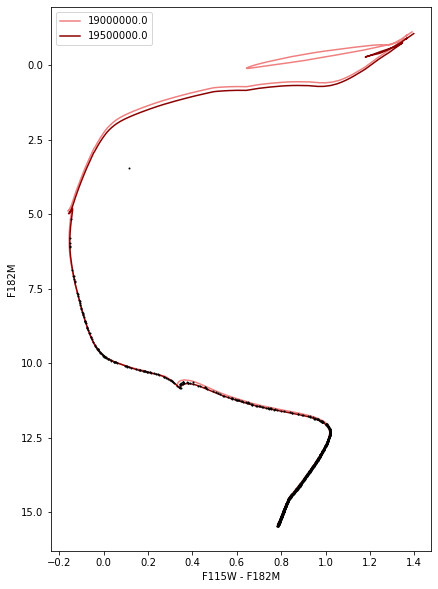

In [10]:
fig, axes = py.subplots(figsize=(15, 10))

# plot CMD
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

for i in range(len(stars)):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')
